In [90]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Part 1

In [5]:
logins = pd.read_json('logins.json')
print(logins.shape)
logins

(93142, 1)


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


In [7]:
logins['login_time'] = pd.to_datetime(logins['login_time'])
logins = logins.set_index('login_time')
logins.head()

""
login_time
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:37
1970-01-01 20:16:36
1970-01-01 20:26:21


In [9]:
print(min(logins.index)) #beginning of data
print(max(logins.index)) #end of data
max(logins.index)-min(logins.index) #duration

1970-01-01 20:12:16
1970-04-13 18:57:38


Timedelta('101 days 22:45:22')

In [10]:
logins['count']=1
logins_every_15 = logins.resample("60T").agg({'count':'sum'})
logins_every_15['day'] = pd.DatetimeIndex(logins_every_15.index).day
logins_every_15['dayofweek'] = pd.DatetimeIndex(logins_every_15.index).dayofweek
logins_every_15['month'] = pd.DatetimeIndex(logins_every_15.index).month
logins_every_15['week'] = pd.DatetimeIndex(logins_every_15.index).week
logins_every_15['hour'] = pd.DatetimeIndex(logins_every_15.index).hour
logins_every_15.head()

C:\Users\prem\AppData\Local\Temp\ipykernel_6076\150201896.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  logins_every_15['week'] = pd.DatetimeIndex(logins_every_15.index).week


,count,day,dayofweek,month,week,hour
login_time,,,,,,
1970-01-01 20:00:00,24,1,3,1,1,20
1970-01-01 21:00:00,9,1,3,1,1,21
1970-01-01 22:00:00,21,1,3,1,1,22
1970-01-01 23:00:00,58,1,3,1,1,23
1970-01-02 00:00:00,53,2,4,1,1,0


In [11]:
logins_every_15.describe()

,count,day,dayofweek,month,week,hour
count,2447.000000,2447.000000,2447.000000,2447.000000,2447.000000,2447.000000
mean,38.063752,14.569268,3.035554,2.259093,8.325296,11.496935
std,30.752820,8.684673,2.013031,1.017375,4.216594,6.923355
min,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,15.000000,7.000000,1.000000,1.000000,5.000000,5.500000
50%,29.000000,14.000000,3.000000,2.000000,8.000000,11.000000
75%,52.000000,22.000000,5.000000,3.000000,12.000000,17.000000
max,237.000000,31.000000,6.000000,4.000000,16.000000,23.000000


In [13]:
logins_every_15[logins_every_15['count']==0]

,count,day,dayofweek,month,week,hour
login_time,,,,,,
1970-01-08 15:00:00,0,8,3,1,2,15
1970-02-19 08:00:00,0,19,3,2,8,8


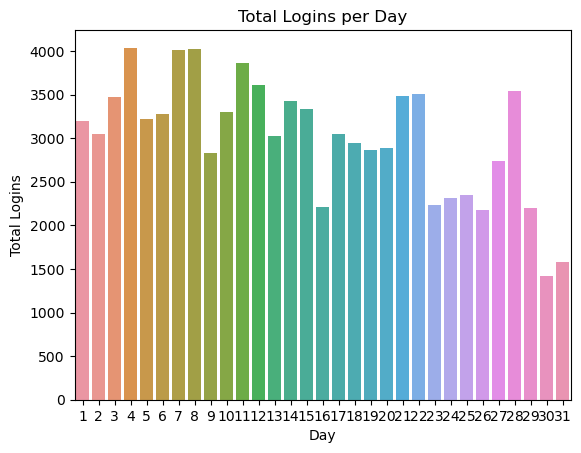

In [34]:
days = logins_every_15.groupby('day').sum()['count']
_ = sns.barplot(x=days.index, y=days)
_.set_xlabel('Day')
_.set_ylabel('Total Logins')
_.set_title('Total Logins per Day')
plt.show()

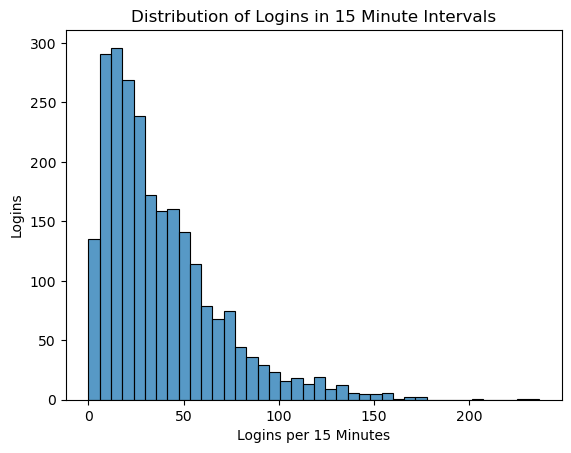

In [35]:
_=sns.histplot(logins_every_15['count'], bins=40)
_.set_xlabel('Logins per 15 Minutes')
_.set_ylabel('Logins')
_.set_title('Distribution of Logins in 15 Minute Intervals')
plt.show()

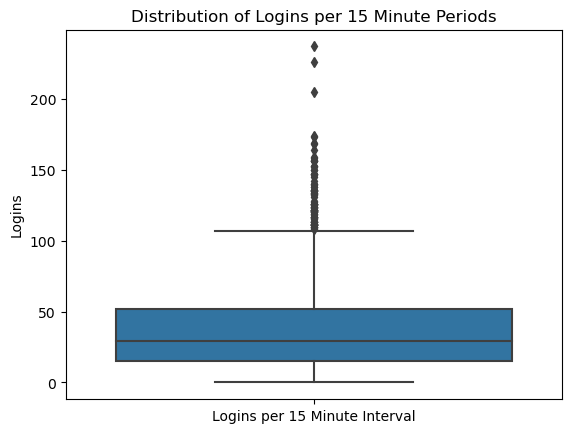

In [32]:
_ = sns.boxplot(logins_every_15['count'])
_.set_xticklabels(['Logins per 15 Minute Interval'])
_.set_ylabel('Logins')
_.set_title('Distribution of Logins per 15 Minute Periods')
plt.show()

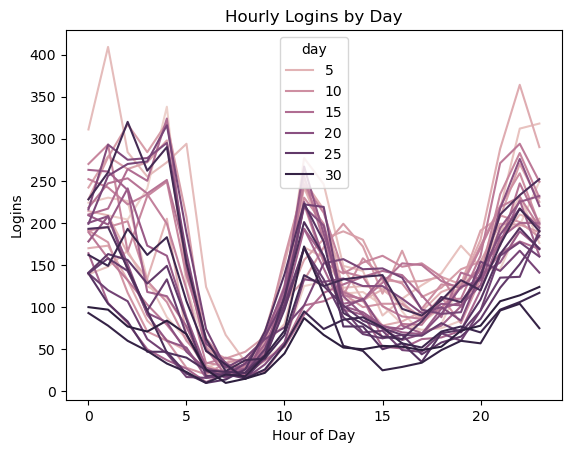

In [37]:
hours = logins_every_15.reset_index().groupby(['hour','day']).agg({'count':'sum'}).reset_index('day')
_ = sns.lineplot(x = hours.index,y=hours['count'], hue=hours['day'])
_.set_title('Hourly Logins by Day')
_.set_xlabel('Hour of Day')
_.set_ylabel('Logins')
plt.show()

there is a significant amount of logins at the hours of 11 pm, 2-3 am, and 11 Am regularly, determining these as the peak hours of activity on the instance.

Data Quality wise there are 2 logins where the count is 0 despite the login data existing. Additionally as there is a large amount of usage between 10pm - 2am which is outside of the normal 8-5 work schedule, there can be some concerns on system management. 

## Part 2

The key measure of success in this experiement would the amount of drivers a city uses for each event. Each driver should be labeled by their original location and will be tracked by event to determine if there is a cross over between the two citys.

For the experiment, driver utilization will be monitored for one month between each city. The null hypothesis in this situation will assume that city's will not have more drivers per event and that the utilization has not changed post reimbursement of drivers. Toll utilization will be monitored between drivers and confirm if the toll utilization has increased between the 2 cities.

Should there be no changes, the city would need to create demand for drivers to utilize the bridge and create scenarios where the bridge would be used more outside of its peak usage. If usage has increased, then the null hypothesis has been proven incorrect and utilization was a key metric for this experiment

## Part 3

In [54]:
rider = pd.read_json('ultimate_data_challenge.json')
print(rider.shape)
rider.head()

(50000, 12)


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


## Basic data exploration

In [40]:
print(rider.dtypes)
rider.describe

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object


<bound method NDFrame.describe of                  city  trips_in_first_30_days signup_date  \
0      King's Landing                       4  2014-01-25   
1             Astapor                       0  2014-01-29   
2             Astapor                       3  2014-01-06   
3      King's Landing                       9  2014-01-10   
4          Winterfell                      14  2014-01-27   
...               ...                     ...         ...   
49995  King's Landing                       0  2014-01-25   
49996         Astapor                       1  2014-01-24   
49997      Winterfell                       0  2014-01-31   
49998         Astapor                       2  2014-01-14   
49999         Astapor                       0  2014-01-18   

       avg_rating_of_driver  avg_surge last_trip_date    phone  surge_pct  \
0                       4.7       1.10     2014-06-17   iPhone       15.4   
1                       5.0       1.00     2014-05-05  Android        0.0   
2 

In [42]:
rider.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

## Data Cleaning

4.601559291274655
4.9


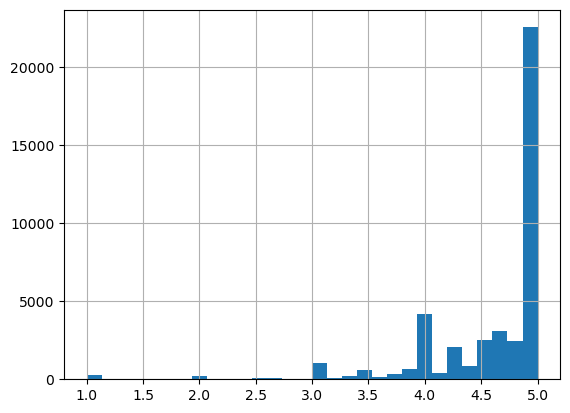

In [51]:
print(rider['avg_rating_of_driver'].mean())
print(rider['avg_rating_of_driver'].median())
rider['avg_rating_of_driver'].hist(bins=30)
plt.show()

In [58]:
rider['avg_rating_of_driver'].fillna(rider['avg_rating_of_driver'].mean(), inplace=True)

4.77815819594771
5.0


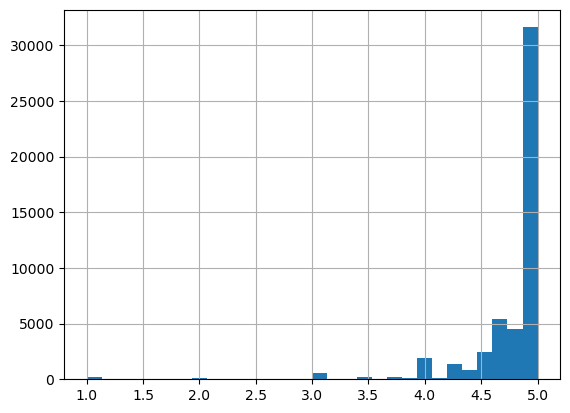

In [53]:
print(rider['avg_rating_by_driver'].mean())
print(rider['avg_rating_by_driver'].median())
rider['avg_rating_by_driver'].hist(bins=30)
plt.show()

In [57]:
rider['avg_rating_by_driver'].fillna(rider['avg_rating_by_driver'].mean(), inplace=True)

In [74]:
rider['phone'].fillna('none',inplace=True)

In [73]:
#Date cleaning and creating variable for modeling
rider['signup_date'] = pd.to_datetime(rider['signup_date'])
rider['last_trip_date'] = pd.to_datetime(rider['last_trip_date'])
rider['signup_days'] = (rider['last_trip_date']-rider['signup_date']).dt.days
rider.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,signup_days,retention
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,143,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,96,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,170,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,47,1


In [75]:
rider.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
signup_days               0
retention                 0
dtype: int64

C:\Users\prem\AppData\Local\Temp\ipykernel_6076\2371584320.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(rider.corr(), annot=True)


<Axes: >

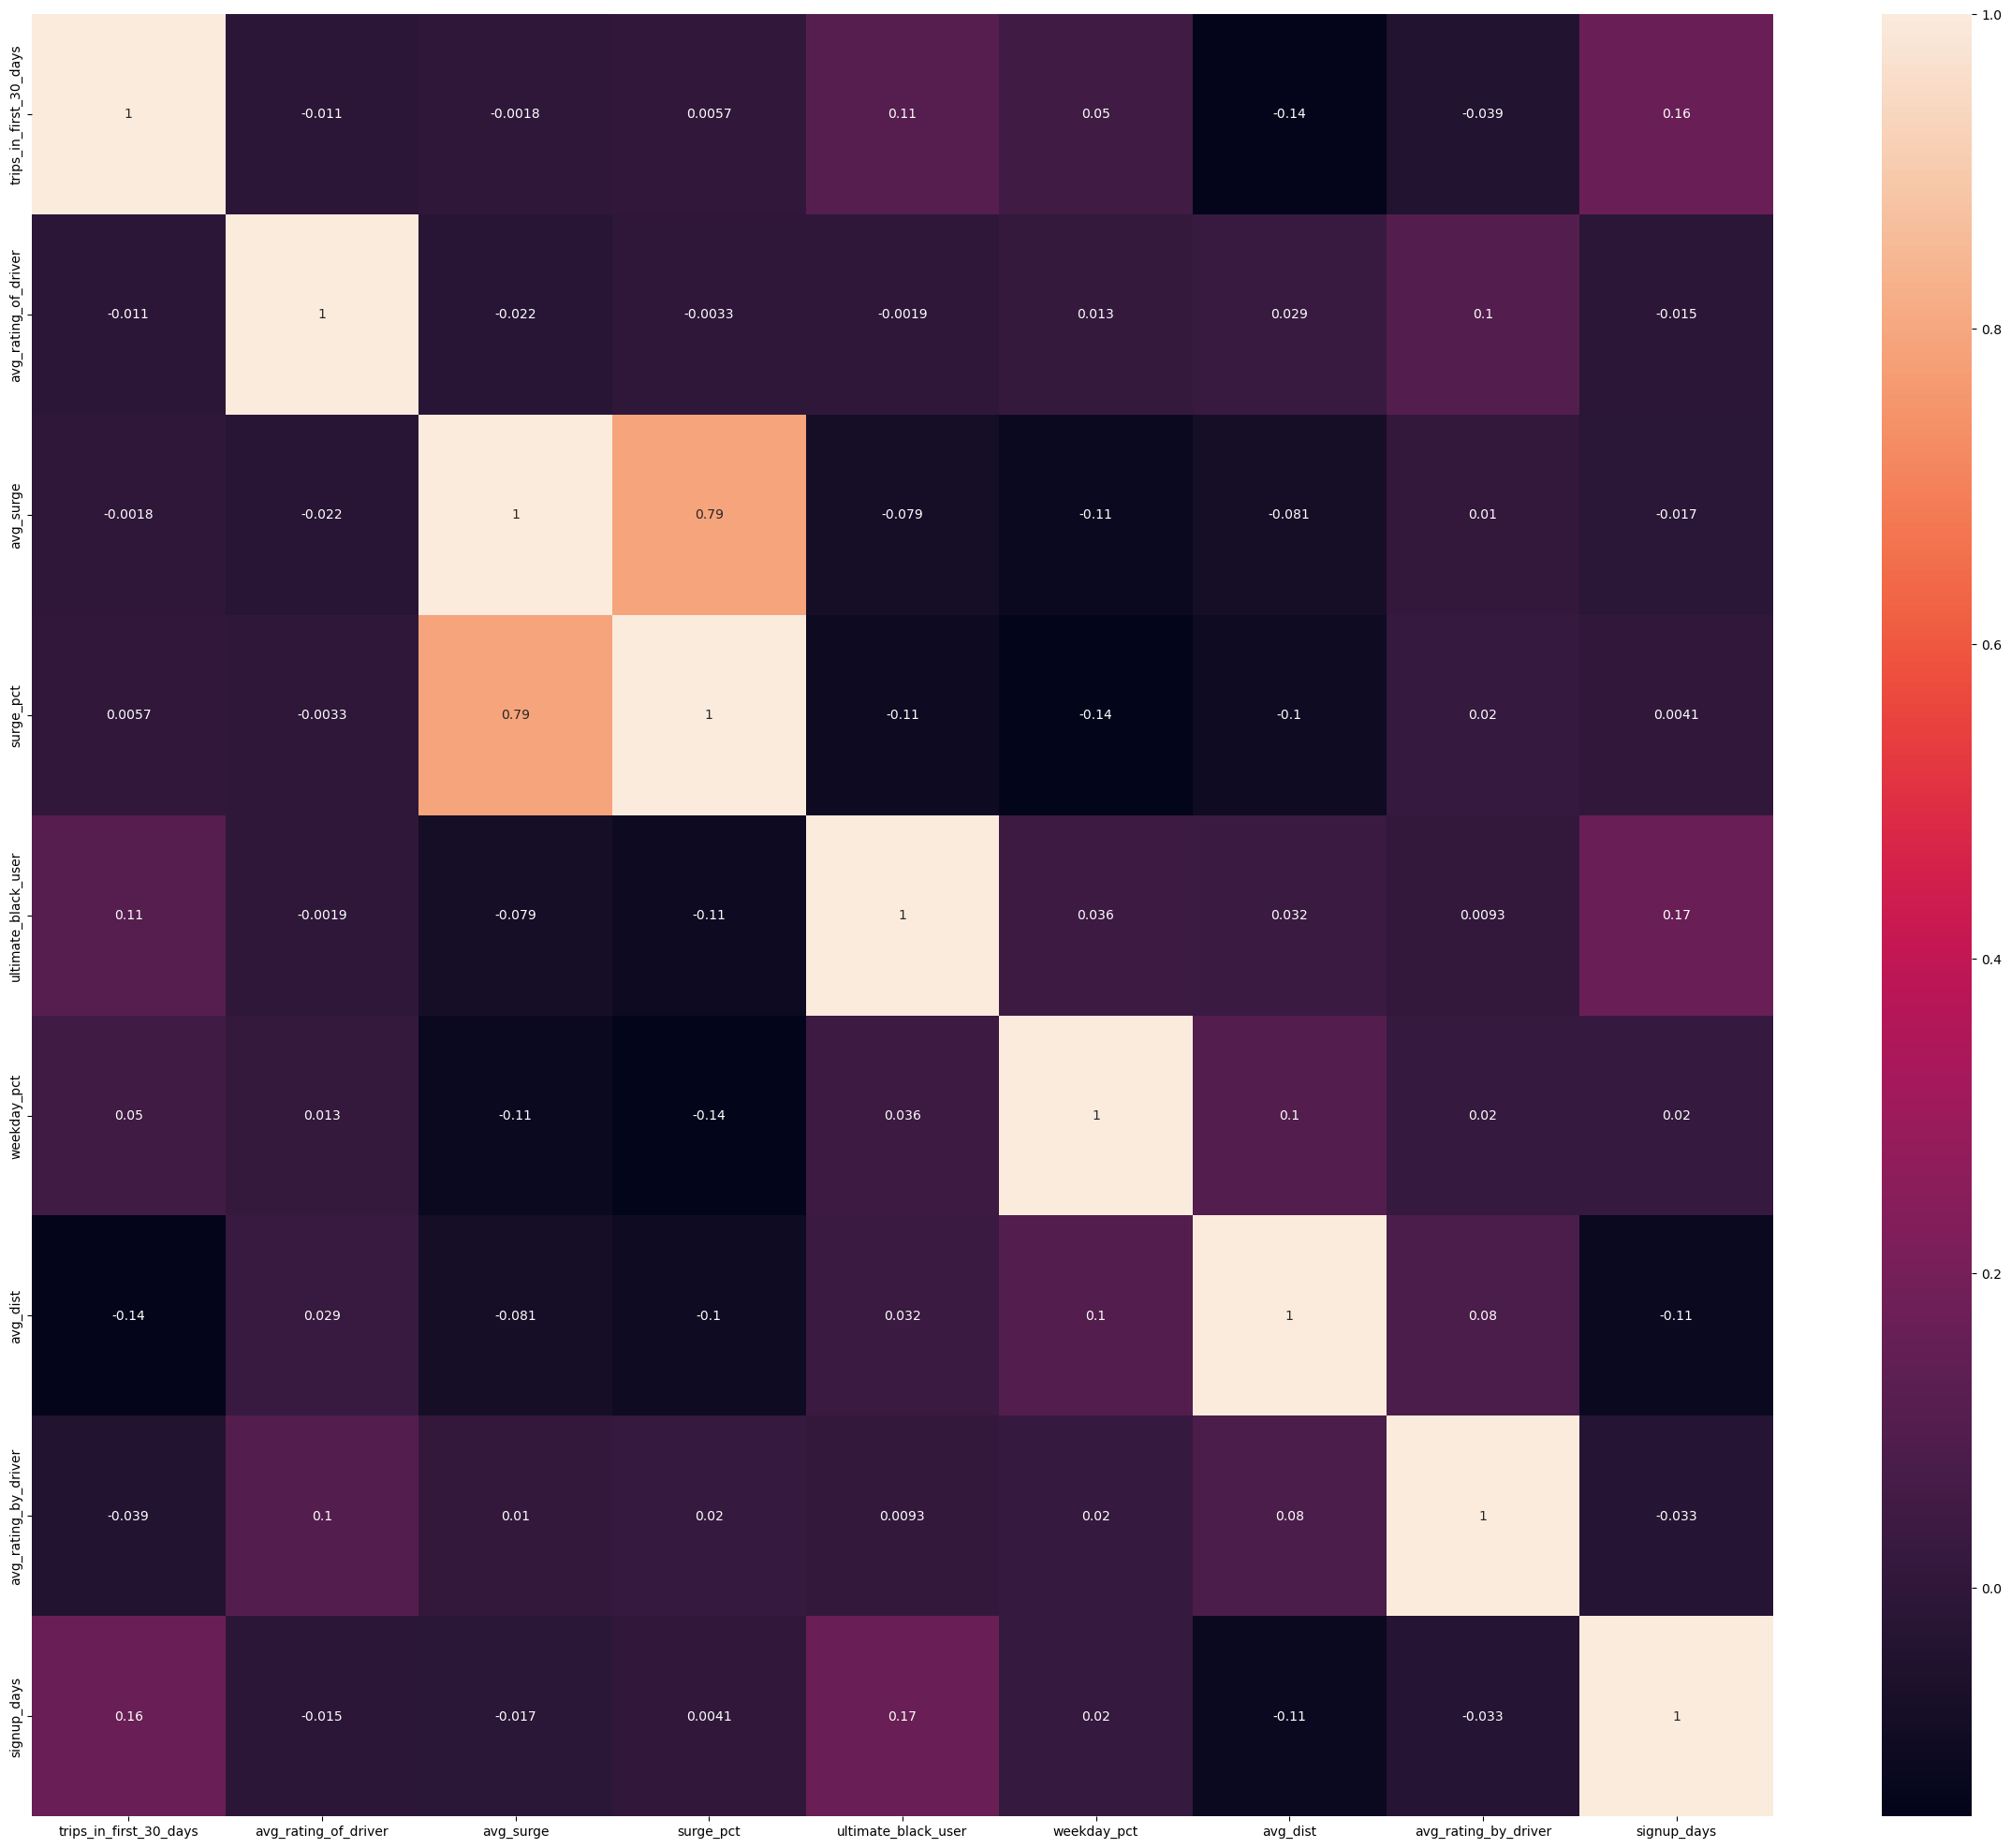

In [64]:
plt.figure(figsize=(30,25))
sns.heatmap(rider.corr(), annot=True)

In [71]:
rider['retention'] = np.where(rider['trips_in_first_30_days']>0, 1, 0)
rider['retention'].sum()/rider['retention'].count()

0.6922

### 69.22% Rider retention within the first 30 days

## Modeling

In [86]:
feat = ['city', 'avg_rating_of_driver',
       'avg_surge', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'signup_days']
X = rider[feat]
y = rider.retention

In [87]:
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.25, random_state = 42)

In [88]:
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [89]:
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)
rf.score(X_test_scaled, y_test)

0.82048

In [93]:
y_pred = rf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test,y_pred)
print('Confusion Matrix')
print(cm)

              precision    recall  f1-score   support

           0       0.73      0.65      0.69      3837
           1       0.85      0.90      0.87      8663

    accuracy                           0.82     12500
   macro avg       0.79      0.77      0.78     12500
weighted avg       0.82      0.82      0.82     12500

Confusion Matrix
[[2493 1344]
 [ 900 7763]]


AUC=0.8822991088639746


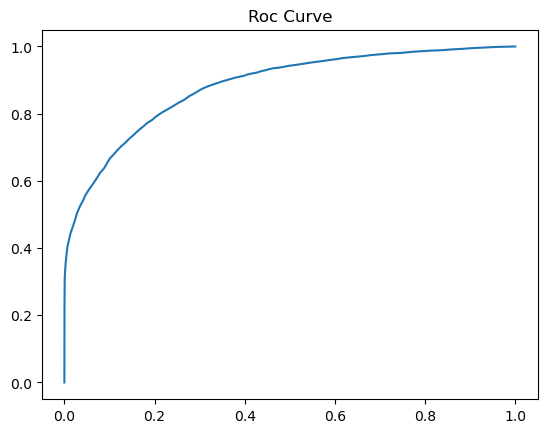

In [100]:
y_pred_proba = rf.predict_proba(X_test_scaled)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
print('AUC='+str(auc))
plt.plot(fpr,tpr)
plt.title('Roc Curve')
plt.show()

In [101]:
features = pd.DataFrame()
features['coef'] = rf.feature_importances_
features = features.set_index(X.columns)
features.coef.nlargest(15)

signup_days             0.400161
avg_dist                0.189264
weekday_pct             0.130536
avg_rating_by_driver    0.075016
avg_rating_of_driver    0.067286
surge_pct               0.051049
avg_surge               0.038556
ultimate_black_user     0.014329
city_Winterfell         0.007403
city_Astapor            0.006422
phone_iPhone            0.006351
city_King's Landing     0.006213
phone_Android           0.006207
phone_none              0.001207
Name: coef, dtype: float64

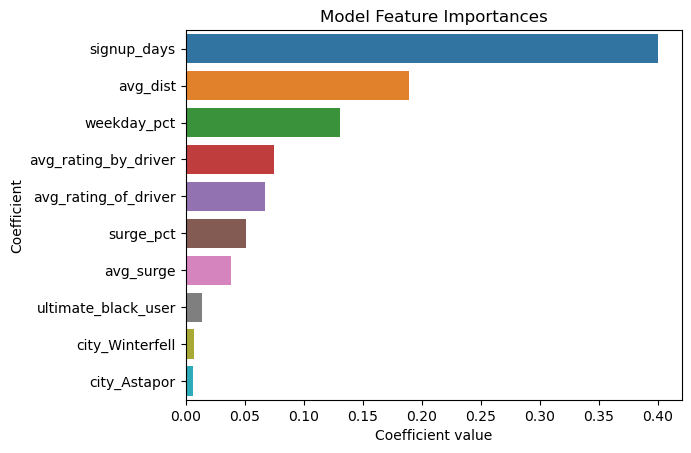

In [103]:
top10 = features.coef.nlargest(10)
sns.barplot(y=top10.index,x=top10.values)
plt.title('Model Feature Importances')
plt.ylabel('Coefficient')
plt.xlabel('Coefficient value')
plt.show()

Ultimate technologies should look to give benefits to users who are currently long term members as that is a major driving factor. By improving relations with current long term riders, avg ratings from both drivers and of drivers will naturally stay high and in turn improving total usage of the platform